In [ ]:
##########################################################複製區塊
import matplotlib.pyplot as plt
import time
from scipy import signal
from time import sleep
import sys
import meep as mp
import numpy as np
import random
import multiprocessing as multi
#setup some constants and parameters
M=2**25
tsim=112e-12
eps0 = 8.854187e-12
hbar = 1.05457182e-34
c = 2.99792458e8
kb = 1.380649e-23
hdk=7.63823258e-12
deltap = np.sqrt(1/3/eps0/hbar/c)*kb
T=30000
frq_min = 0
frq_max = 100/2/np.pi
nfreq = 1000
fcen = (frq_min + frq_max)/2
df = frq_max - frq_min
#define square root of Dn function
def Dnsqt(wla,T):
    return np.sqrt(6*hdk**2*wla/(np.exp(hdk*wla/T)-1)/T**2/np.pi)

#generate an array of the square root of Dn function
Dsqt = []
for n in range(1,M):
    Dsqt.append(Dnsqt(2*np.pi*n/tsim,T))

#define how many times to run to average the results
Ncomp= 5
nfreq =  1000
#define the starting sum of the result
Efsum = np.zeros(nfreq)
Ens = np.zeros(2**26)
resolution = 1000
dA = 0.5
dB = 0.02
dpml = 1.0
sz = dpml*2+dA*2+dB
cell = mp.Vector3(0, 0, sz)
pml_layers = [mp.PML(dpml)]



for i in range(Ncomp):
    
    def random_En(t):
        #generate random numbers
        M0 = np.random.normal(0,1)
        Mlp = np.random.normal(0,1,M-1)
        Nlp = np.random.normal(0,1,M-1)
        MM = np.random.normal(0,1)
    
        #generate the array of the fourier transform of E field, we generate l=0 and l=-M separately. 
        #for l=1 to M-1 and l=-1 to -(M-1) are conjutated to each other. 
        #we contruct the whole array by gluing them together by the order from l=0 -> l=M-1 -> l=-M -> l=-(m-1) -> l=-1
        Ef0 = np.array([M0*np.sqrt(6*hdk/np.pi/T)])
        Eflp = np.multiply((Mlp + 1j*Nlp), Dsqt)
        Eflm = np.flip(np.conjugate(Eflp))
        EfM = np.array([MM*Dnsqt(2*np.pi*M/tsim,T)])
        Ef = np.hstack((Ef0,Eflp,EfM,Eflm))
    
        #we normalize Ef and compute its inverse fast fourier transform
        Efn = deltap*T/np.sqrt(tsim)*Ef
        En = np.fft.ifft(Efn)*M
        return En
    En0 = random_En(1)
    En1 = random_En(1)
    #generate some feedback to check the progress of the loop
    x = i/Ncomp*100
    sys.stdout.write('\r')
    sys.stdout.write("[%-20s] %d%%" % ('a'*int(x), int(x)))
    sys.stdout.flush()
    sleep(0.0001)
    
    
    def source0(t):
        f = int(t*2000)
        return En0[f]
    def source1(t):
        f = int(t*2000)
        return En1[f]
    


    sources = [mp.Source(mp.CustomSource(src_func=source0),
                     component=mp.Ex,
                     center=mp.Vector3(0,0,-0.5*sz+dpml),
                     ),
              mp.Source(mp.CustomSource(src_func=source1),
                     component=mp.Ex,
                     center=mp.Vector3(0,0,0.5*sz-dpml),
                     )]
    
    def BlockAB(N, center):
        geometry = []
        for i in range(N):
            geometry = np.append(geometry, mp.Block(mp.Vector3(0,0,dA),
                     center=mp.Vector3(0,0,0-dA/2-dB/2),
                     material=mp.Medium(epsilon=1)))
            geometry = np.append(geometry, mp.Block(mp.Vector3(0,0,dB),
                     center=mp.Vector3(0,0,0),
                     material=mp.Medium(epsilon=36)))
            geometry = np.append(geometry, mp.Block(mp.Vector3(0,0,dA),
                     center=mp.Vector3(0,0,dB/2+dA/2),
                     material=mp.Medium(epsilon=1)))
        geometry = geometry.tolist()
        return geometry
    sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    sources=sources,   
                    #dimensions = 2,
                    Courant = 1,
                    resolution=resolution,
                    geometry=BlockAB(1,0))
    
    

    # transmitted flux
    tran_fr = mp.FluxRegion(center=mp.Vector3(0,0,random.uniform(-0.01,0.01)))
    tran = sim.add_energy(fcen, df, nfreq, tran_fr)
    
    
    sim.run(until=33440)

    tran_flux = mp.get_magnetic_energy(tran)
    Ts = []
    for i in range(nfreq):
        Ts = np.append(Ts,tran_flux[i])    
    Efsum += Ts
    
    

#average the final result
Efavg = Efsum/Ncomp

#save data to some file or reload file to write more data on it



[                    ] 0%-----------
Initializing structure...
time for choose_chunkdivision = 0.000514984 s
Working in 3D dimensions.
Computational cell is 0.001 x 0.001 x 3.02 with resolution 1000
     block, center = (0,0,-0.26)
          size (0,0,0.5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,0)
          size (0,0,0.02)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (36,36,36)
     block, center = (0,0,0.26)
          size (0,0,0.5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.062186 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2090.0)

Meep progress: 1.768/2090.0 = 0.1% done in 4.0s, 4726.9s to go
on time step 1769 (time=1.769), 0.0022617 s/step
Meep progress: 3.617/2090.0 = 0.2% done in 8.0s, 4616.2s to go
on time step 3619 (time=3.619), 0.00216304 s/step
Meep progress: 5.471/2090.0 = 0.3% done in 12.0s, 4573.4s to go
on time step 5474 (time=5.474), 0.00215719 s/step
Meep progress: 7.312/2090.0 = 0.3% done in 16.0s, 4558.3s to go
on time step 7317 (time=7.317), 0.00217082 s/step
Meep progress: 9.157/2090.0 = 0.4% done in 20.0s, 4545.8s to go
on time step 9163 (time=9.163), 0.00216774 s/step
Meep progress: 11.001/2090.0 = 0.5% done in 24.0s, 4536.8s to go
on time step 11008 (time=11.008), 0.00216811 s/step
Meep progress: 12.764000000000001/2090.0 = 0.6% done in 28.0s, 4558.0s to go
on time step 12772 (time=12.772), 0.00226861 s/step
Meep progress: 14.598/2090.0 = 0.7% done in 32.0s, 4550.6s to go
on time step 14607 (time=14.607), 0.00218104 s/step
Meep progress: 16.448/2090.0 = 0.8% done in 36.0s, 4539.6s to go
on ti

FloatProgress(value=0.0, description='0% done ', max=2090.0)

Meep progress: 1.828/2090.0 = 0.1% done in 4.0s, 4569.6s to go
on time step 1829 (time=1.829), 0.00218732 s/step
Meep progress: 3.716/2090.0 = 0.2% done in 8.0s, 4491.7s to go
on time step 3718 (time=3.718), 0.00211845 s/step
Meep progress: 5.6160000000000005/2090.0 = 0.3% done in 12.0s, 4454.6s to go
on time step 5618 (time=5.618), 0.00210595 s/step
Meep progress: 7.506/2090.0 = 0.4% done in 16.0s, 4439.7s to go
on time step 7509 (time=7.509), 0.00211617 s/step
Meep progress: 9.391/2090.0 = 0.4% done in 20.0s, 4431.9s to go
on time step 9394 (time=9.394), 0.00212256 s/step
Meep progress: 11.273/2090.0 = 0.5% done in 24.0s, 4426.3s to go
on time step 11277 (time=11.277), 0.00212529 s/step
Meep progress: 13.165000000000001/2090.0 = 0.6% done in 28.0s, 4417.9s to go
on time step 13169 (time=13.169), 0.00211457 s/step
Meep progress: 15.051/2090.0 = 0.7% done in 32.0s, 4412.4s to go
on time step 15055 (time=15.055), 0.00212132 s/step
Meep progress: 16.934/2090.0 = 0.8% done in 36.0s, 4408.

FloatProgress(value=0.0, description='0% done ', max=2090.0)

Meep progress: 1.799/2090.0 = 0.1% done in 4.0s, 4644.3s to go
on time step 1800 (time=1.8), 0.00222292 s/step
Meep progress: 3.644/2090.0 = 0.2% done in 8.0s, 4581.6s to go
on time step 3645 (time=3.645), 0.00216838 s/step
Meep progress: 5.494/2090.0 = 0.3% done in 12.0s, 4554.4s to go
on time step 5495 (time=5.495), 0.00216277 s/step
Meep progress: 7.34/2090.0 = 0.4% done in 16.0s, 4541.4s to go
on time step 7341 (time=7.341), 0.00216761 s/step
Meep progress: 9.186/2090.0 = 0.4% done in 20.0s, 4531.9s to go
on time step 9187 (time=9.187), 0.00216705 s/step
Meep progress: 11.03/2090.0 = 0.5% done in 24.0s, 4524.8s to go
on time step 11032 (time=11.032), 0.002169 s/step
Meep progress: 12.870000000000001/2090.0 = 0.6% done in 28.0s, 4520.2s to go
on time step 12872 (time=12.872), 0.00217401 s/step
Meep progress: 14.724/2090.0 = 0.7% done in 32.0s, 4511.3s to go
on time step 14727 (time=14.727), 0.00215734 s/step
Meep progress: 16.57/2090.0 = 0.8% done in 36.0s, 4505.9s to go
on time ste

FloatProgress(value=0.0, description='0% done ', max=2090.0)

Meep progress: 1.7810000000000001/2090.0 = 0.1% done in 4.0s, 4690.3s to go
on time step 1782 (time=1.782), 0.00224498 s/step
Meep progress: 3.623/2090.0 = 0.2% done in 8.0s, 4608.2s to go
on time step 3624 (time=3.624), 0.00217222 s/step
Meep progress: 5.461/2090.0 = 0.3% done in 12.0s, 4581.4s to go
on time step 5463 (time=5.463), 0.00217619 s/step
Meep progress: 7.304/2090.0 = 0.3% done in 16.0s, 4563.1s to go
on time step 7307 (time=7.307), 0.00217028 s/step
Meep progress: 9.148/2090.0 = 0.4% done in 20.0s, 4550.4s to go
on time step 9151 (time=9.151), 0.00216999 s/step
Meep progress: 10.992/2090.0 = 0.5% done in 24.0s, 4540.4s to go
on time step 10995 (time=10.995), 0.00216933 s/step
Meep progress: 12.84/2090.0 = 0.6% done in 28.0s, 4530.6s to go
on time step 12844 (time=12.844), 0.00216445 s/step
Meep progress: 14.574/2090.0 = 0.7% done in 32.0s, 4558.1s to go
on time step 14578 (time=14.578), 0.00230754 s/step
Meep progress: 16.405/2090.0 = 0.8% done in 36.0s, 4551.5s to go
on t

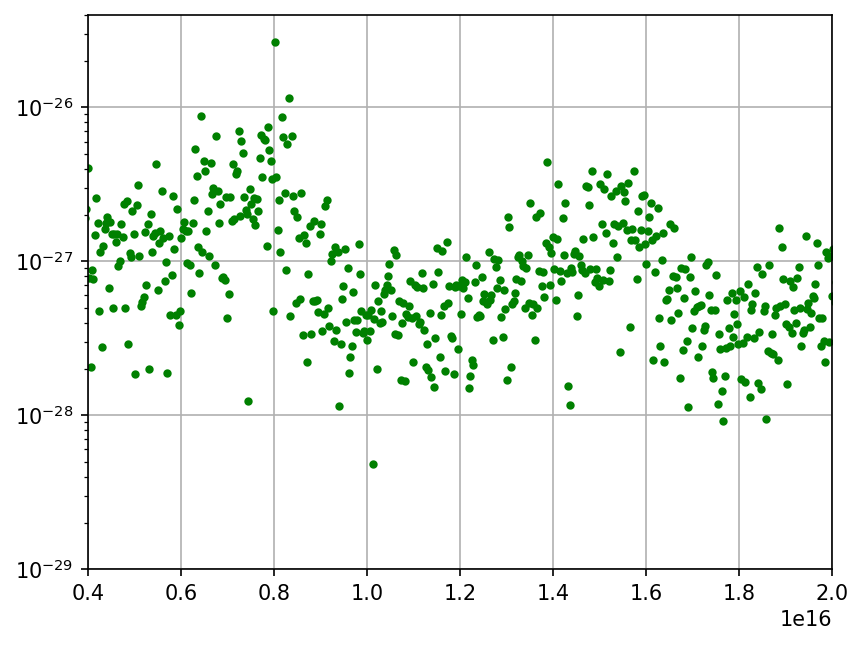

In [5]:
plt.figure(dpi=150)
freqs = np.linspace(0,30e15,1000)
plt.plot(freqs,Efavg*tsim*eps0*4*np.pi*3/2**21,'g''.')
plt.xlim(4e15,20e15)
plt.yscale("log")
plt.ylim(0.1e-28,400e-28)
plt.grid()
plt.savefig('112ps_source_test_detector_photonic_crystal_30000.png')
plt.show()

np.savez("112ps_test_custom_source_photonic_crystal_30000.npz", Efavg_30000 = Efavg)

In [3]:
from PIL import Image

def transPNG(srcImageName, dstImageName):
    img = Image.open(srcImageName)
    img = img.convert("RGBA")
    datas = img.getdata()
    newData = list()
    for item in datas:
        if item[0] > 225 and item[1] > 225 and item[2] > 225:
            newData.append((255, 255, 255, 0))
        else:
            newData.append(item)
            
    img.putdata(newData)
    img.save(dstImageName, "PNG")
transPNG('test_detector_photonic_crystal_30000.png','trans_test_detector_photonic_crystal_30000.png')